In [1]:
%pip install msgpack-python avro

You should consider upgrading via the '/home/nano/projects/tree-ensemble-model-management/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import sys
from time import time

sys.path.append("..")

from utils.encoding import (
    save_model_avro,
    load_model_avro,
    save_model_msgpack,
    load_model_msgpack,
)
from utils.metrics import mean_and_std
from utils.xgboost import load_model_json, save_model_json

In [4]:
xgboost_path = "/home/nano/projects/tree-ensemble-model-management/models/xgboost"

daily_path = xgboost_path + "/daily"
daily_100 = daily_path + "/100trees"
daily_1000 = daily_path + "/1000trees"
daily_10000 = daily_path + "/10000trees"

fivedays_path = xgboost_path + "/5days"
fivedays_100 = fivedays_path + "/100trees"
fivedays_1000 = fivedays_path + "/1000trees"
fivedays_10000 = fivedays_path + "/10000trees"

In [8]:
def get_metrics(model_dir):
    dt_json_load = []
    dt_json_save = []
    json_sizes = []
    dt_ubj_load = []
    dt_ubj_save = []
    ubj_sizes = []
    dt_avro_load = []
    dt_avro_save = []
    avro_sizes = []
    dt_msgpack_load = []
    dt_msgpack_save = []
    msgpack_sizes = []

    for model_file in os.listdir(model_dir):
        model_path = os.path.join(model_dir, model_file)

        # JSON
        # Load
        t0 = time()
        booster = load_model_json(model_path)
        dt_json_load.append(time() - t0)

        # Save
        t0 = time()
        save_model_json(booster, model_path)
        dt_json_save.append(time() - t0)

        # Size
        json_size = os.path.getsize(model_path)
        json_sizes.append(1)

        # UBJ
        # Save
        ubj_path = "model.ubj"
        t0 = time()
        save_model_json(booster, ubj_path)
        dt_ubj_save.append(time() - t0)

        # Load
        t0 = time()
        ubj_booster = load_model_json(ubj_path)
        dt_ubj_load.append(time() - t0)

        # Size
        ubj_sizes.append(json_size / os.path.getsize(ubj_path))
        os.remove(ubj_path)

        # AVRO
        # Save
        avro_path = "test.avro"
        t0 = time()
        save_model_avro(booster, avro_path)
        dt_avro_save.append(time() - t0)

        # Load
        t0 = time()
        avro_booster = load_model_avro(avro_path)
        dt_avro_load.append(time() - t0)

        # Size
        avro_sizes.append(json_size / os.path.getsize(avro_path))
        os.remove(avro_path)

        # MSGPACK
        msgpack_path = "test.msgpack"
        # Save
        t0 = time()
        save_model_msgpack(booster, msgpack_path)
        dt_msgpack_save.append(time() - t0)

        # # Load
        t0 = time()
        msgpack_booster = load_model_msgpack(msgpack_path)
        dt_msgpack_load.append(time() - t0)

        # Size
        msgpack_sizes.append(json_size / os.path.getsize(msgpack_path))
        os.remove(msgpack_path)

        assert (
            booster.get_dump() == avro_booster.get_dump() == msgpack_booster.get_dump()
        )

    # Evaluation
    # Load
    json_mean, json_std = mean_and_std(dt_json_load)
    ubj_mean, ubj_std = mean_and_std(dt_ubj_load)
    avro_mean, avro_std = mean_and_std(dt_avro_load)
    msgpack_mean, msgpack_std = mean_and_std(dt_msgpack_load)
    dt_load = {
        "JSON": {"mean": json_mean, "std": json_std},
        "UBJ": {"mean": ubj_mean, "std": ubj_std},
        "AVRO": {"mean": avro_mean, "std": avro_std},
        "MsgPack": {"mean": msgpack_mean, "std": msgpack_std},
    }
    # Save
    json_mean, json_std = mean_and_std(dt_json_save)
    ubj_mean, ubj_std = mean_and_std(dt_ubj_save)
    avro_mean, avro_std = mean_and_std(dt_avro_save)
    msgpack_mean, msgpack_std = mean_and_std(dt_msgpack_save)
    dt_save = {
        "JSON": {"mean": json_mean, "std": json_std},
        "UBJ": {"mean": ubj_mean, "std": ubj_std},
        "AVRO": {"mean": avro_mean, "std": avro_std},
        "MsgPack": {"mean": msgpack_mean, "std": msgpack_std},
    }

    # Size
    json_mean, json_std = mean_and_std(json_sizes)
    ubj_mean, ubj_std = mean_and_std(ubj_sizes)
    avro_mean, avro_std = mean_and_std(avro_sizes)
    msgpack_mean, msgpack_std = mean_and_std(msgpack_sizes)
    sizes = {
        "JSON": {"mean": json_mean, "std": json_std},
        "UBJ": {"mean": ubj_mean, "std": ubj_std},
        "AVRO": {"mean": avro_mean, "std": avro_std},
        "MsgPack": {"mean": msgpack_mean, "std": msgpack_std},
    }

    return sizes, dt_save, dt_load

In [9]:
sizes_100, save_100, load_100 = get_metrics(daily_100)


In [10]:
sizes_1000, save_1000, load_1000 = get_metrics(daily_1000)

In [11]:
sizes_10000, save_10000, load_10000 = get_metrics(daily_10000)

In [12]:
import matplotlib.pyplot as plt
import numpy as np


def plot(sample1, sample2, sample3, ylabel, title):
    # Organizing the data
    means_json = [
        sample1["JSON"]["mean"],
        sample2["JSON"]["mean"],
        sample3["JSON"]["mean"],
    ]
    stds_json = [sample1["JSON"]["std"], sample2["JSON"]["std"], sample3["JSON"]["std"]]

    means_ubj = [
        sample1["UBJ"]["mean"],
        sample2["UBJ"]["mean"],
        sample3["UBJ"]["mean"],
    ]
    stds_ubj = [sample1["UBJ"]["std"], sample2["UBJ"]["std"], sample3["UBJ"]["std"]]

    means_avro = [
        sample1["AVRO"]["mean"],
        sample2["AVRO"]["mean"],
        sample3["AVRO"]["mean"],
    ]
    stds_avro = [sample1["AVRO"]["std"], sample2["AVRO"]["std"], sample3["AVRO"]["std"]]

    means_msgpack = [
        sample1["MsgPack"]["mean"],
        sample2["MsgPack"]["mean"],
        sample3["MsgPack"]["mean"],
    ]
    stds_msgpack = [
        sample1["MsgPack"]["std"],
        sample2["MsgPack"]["std"],
        sample3["MsgPack"]["std"],
    ]

    # Sample labels
    labels = ["100 Trees", "1000 Trees", "10000 Trees"]

    # Setting the positions of the bars
    x = np.arange(len(labels))  # the sample locations
    width = 0.2  # the width of the bars

    # Creating the plot
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, means_json, width, yerr=stds_json, label="JSON")
    rects2 = ax.bar(x, means_ubj, width, yerr=stds_ubj, label="UBJ")
    rects3 = ax.bar(x + width, means_avro, width, yerr=stds_avro, label="AVRO")
    rects4 = ax.bar(
        x + (2 * width), means_msgpack, width, yerr=stds_msgpack, label="MsgPack"
    )

    # Adding some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(bottom=0)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Function to attach a text label above each bar
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    # Attaching the labels
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    # Showing the plot
    plt.tight_layout()
    plt.show()

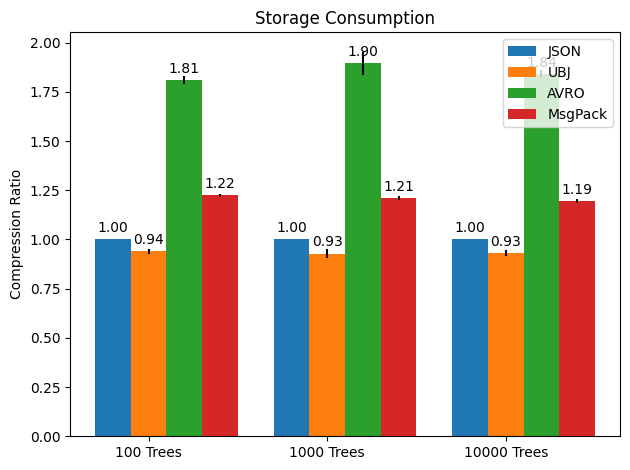

In [13]:
plot(sizes_100, sizes_1000, sizes_10000, ylabel="Compression Ratio", title="Storage Consumption")

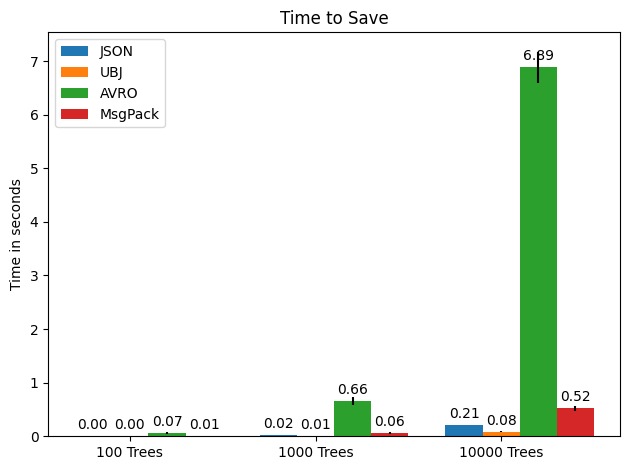

In [14]:
plot(save_100, save_1000, save_10000, ylabel="Time in seconds", title="Time to Save")

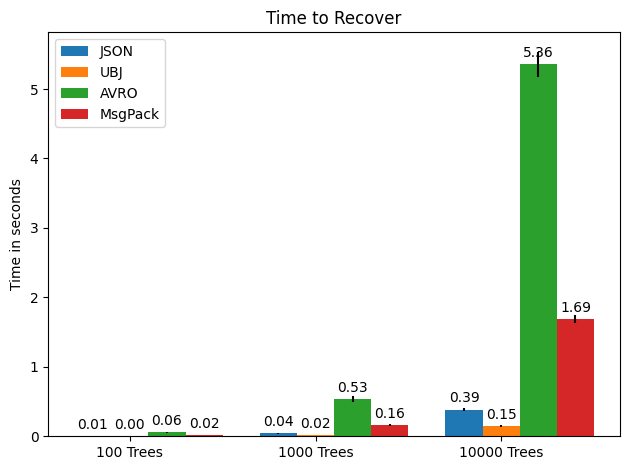

In [15]:
plot(load_100, load_1000, load_10000, ylabel="Time in seconds", title="Time to Recover")